# GARCH

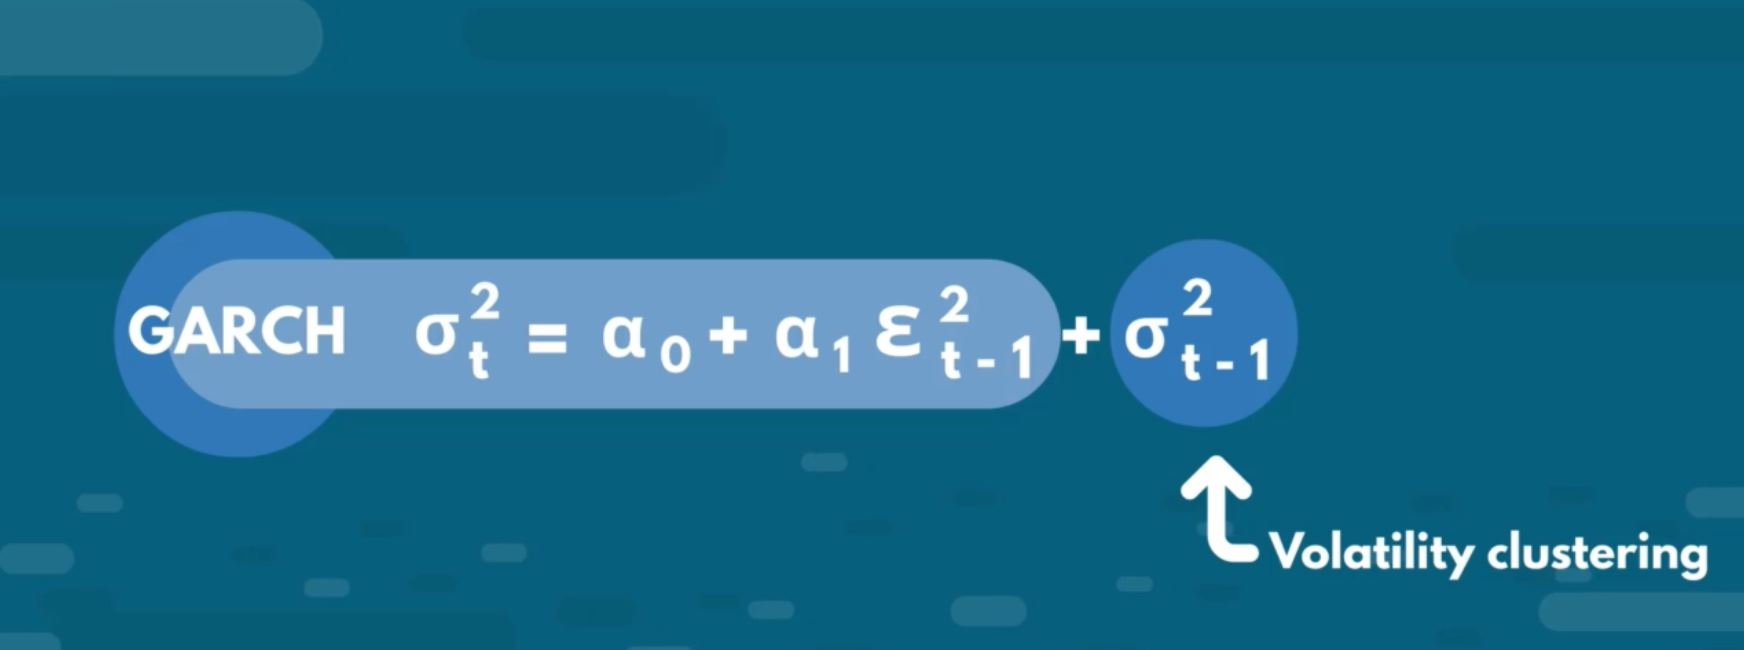

In [1]:
from IPython.display import Image
Image(filename='GARCHeqn.jpg')

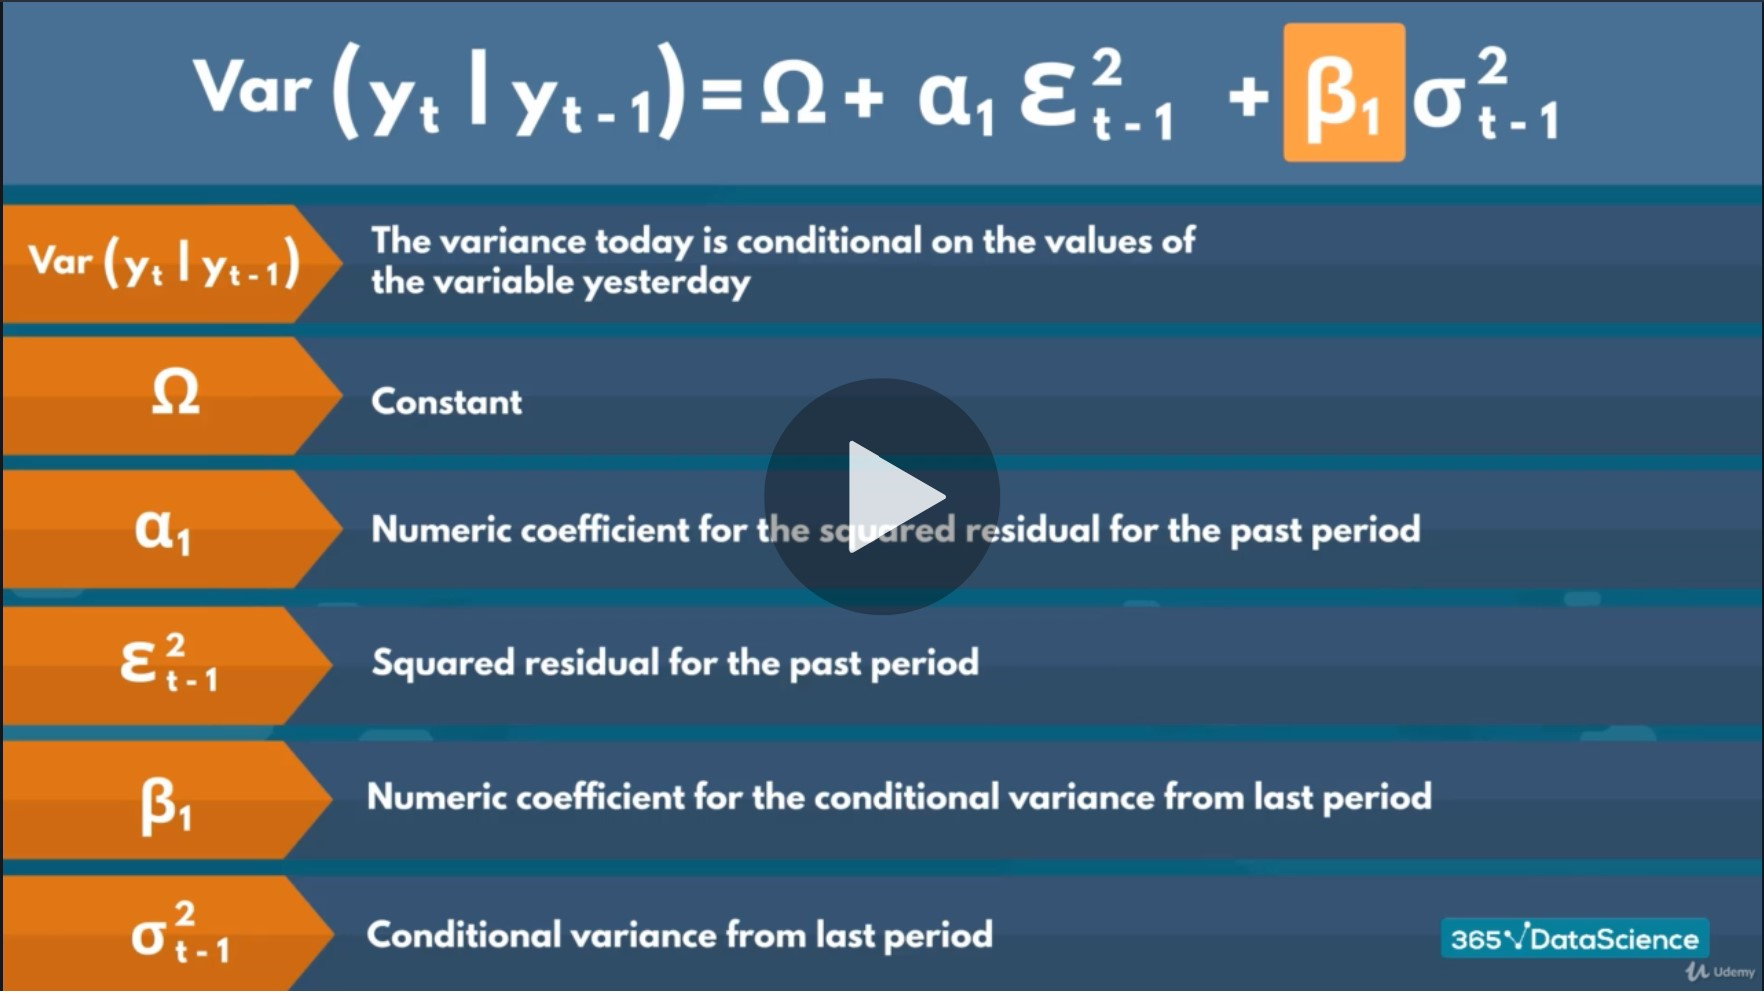

In [2]:
Image(filename='GARCHvars.jpg')

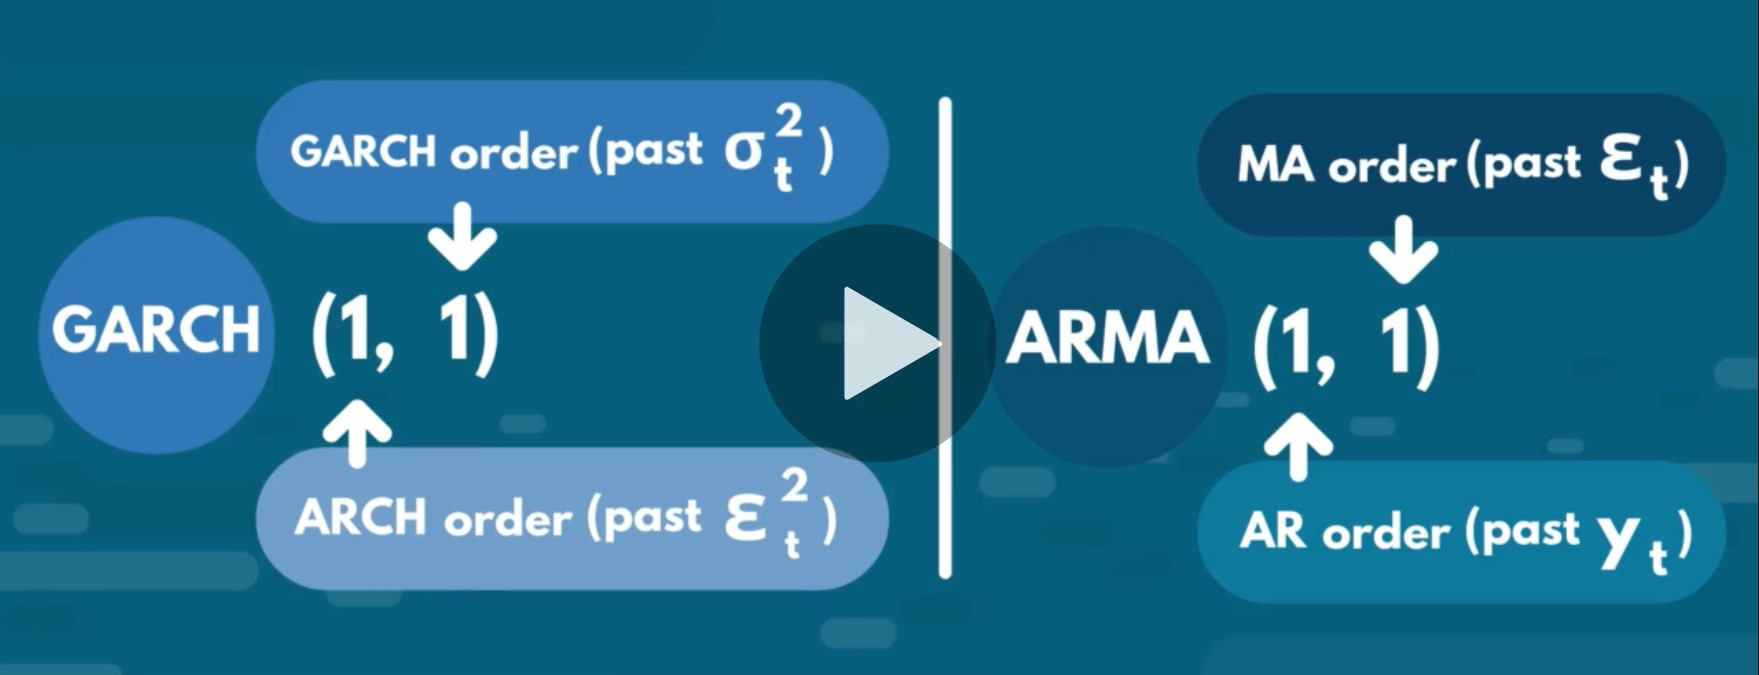

In [3]:
Image(filename='GARCHorder.jpg')

The GARCH component is equivalent to AR component and ARCH component is equivalent to MA components.

ARMA(p,q) is equivalent to GARCH(p,q)
p --> past values
q --> past errors

GARCH can be defined as the squared ARMA model for the error terms of the mean equation. However we also have complex ARMA-GARCH model.
ARMA(p,q) is used for the mean equation and GARCH(p,q) is used for the variance equation. Also the p and q of ARMA may not match with GARCH.  

In [4]:
import numpy as np
import pandas as pd
import yfinance 

# Ignoring warning messages
import warnings 
warnings.filterwarnings("ignore")

In [5]:
# Getting the current date
from datetime import date
today = date.today()
today

datetime.date(2020, 7, 26)

In [6]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", #The time series we are interested in - (in our case, these are the S&P, FTSE, NIKKEI and DAX)
                              start = "1994-01-07", #The starting date of our data set
                              end = today, #The ending date of our data set (at the time of upload, this is the current date)
                              interval = "1d", #The distance in time between two recorded observations. Since we're using daily closing prices, we set it equal to "1d", which indicates 1 day. 
                              group_by = 'ticker', #The way we want to group the scraped data. Usually we want it to be "ticker", so that we have all the information about a time series in 1 variable.
                              auto_adjust = True, #Automatically adjuss the closing prices for each period. 
                              treads = True) #Whether to use threads for mass downloading.

[*********************100%***********************]  4 of 4 completed


In [7]:
# Creating a back up copy in case we remove/alter elements of the data by mistake
df_comp = raw_data.copy()

In [8]:
# Adding new columns to the data set
df_comp['spx'] = df_comp['^GSPC'].Close
df_comp['dax'] = df_comp['^GDAXI'].Close
df_comp['ftse'] = df_comp['^FTSE'].Close
df_comp['nikkei'] = df_comp['^N225'].Close

In [9]:
df_comp = df_comp.iloc[1:] # Removing the first elements, since we always start 1 period before the first, due to time zone differences of closing prices
del df_comp['^N225']  # Removing the original tickers of the data set
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b') # Setting the frequency of the data
df_comp=df_comp.fillna(method='ffill') # Filling any missing values

In [10]:
print (df_comp.head()) # Displaying the first 5 elements to make sure the data was scrapped correctly
print (df_comp.tail()) # Making sure of the last day we're including in the series

                   spx          dax         ftse        nikkei
                                                              
Date                                                          
1994-01-07  469.899994  2224.949951  3446.000000  18124.009766
1994-01-10  475.269989  2225.000000  3440.600098  18443.439453
1994-01-11  474.130005  2228.100098  3413.800049  18485.250000
1994-01-12  474.170013  2182.060059  3372.000000  18793.880859
1994-01-13  472.470001  2142.370117  3360.000000  18577.259766
                    spx           dax         ftse        nikkei
                                                                
Date                                                            
2020-07-20  3251.840088  13046.919922  6261.500000  22717.480469
2020-07-21  3257.300049  13171.830078  6269.700195  22884.220703
2020-07-22  3276.020020  13104.250000  6207.100098  22751.609375
2020-07-23  3235.659912  13103.389648  6211.399902  22751.609375
2020-07-24  3215.629883  12838.059570  61

In [11]:
# while dealing with huge database and you want to analyse only one column
df_comp.spx.isna().sum()

0

## Creating Returns

In [12]:
df_comp['market_value']=df_comp.ftse
df_comp['returns'] = df_comp.market_value.pct_change(1)*100
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

In [13]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [14]:
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.tsa.arima_model as sta
import scipy.stats.distributions as ssd
from scipy.stats.distributions import chi2 
from arch import arch_model
from math import sqrt

## LLR Test

In [15]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit(start_ar_lags = 15).llf
    L2 = mod_2.fit(start_ar_lags = 15).llf
    LR = (2*(L2-L1))    
    p = ssd.chi2.sf(LR, DF).round(3)
    return p

## The Simple GARCH Model

In [16]:
model_garch_1_1 = arch_model(df.returns[1:], mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_1_1 = model_garch_1_1.fit(update_freq = 5)
results_garch_1_1.summary()

# Here p is the ARCH order and q is the GARCH order in the arch_model function.

Iteration:      5,   Func. Count:     35,   Neg. LLF: 7581.818711266142
Iteration:     10,   Func. Count:     65,   Neg. LLF: 7536.171796612216
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7536.171796612216
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -7536.17
Distribution:                  Normal   AIC:                           15080.3
Method:            Maximum Likelihood   BIC:                           15106.8
                                        No. Observations:                 5539
Date:                Sun, Jul 26 2020   Df Residuals:                     5535
Time:                        15:29:48   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0430  1.108e-02      3.886  1.017e-04 [2.134e-02,6.475e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0112  2.955e-03      3.806  1.411e-04 [5.456e-03,1.704e-02]
alpha[1]       0.0848  1.097e-02      7.724  1.129e-14   [6.325e-02,  0.106]
beta[1]        0.9067  1.195e-02     75.900      0.000     [  0.883,  0.930]
============================================================================

Covariance estimator: robust
"""

## Higher-Lag GARCH Models

In [17]:
model_garch_1_2 = arch_model(df.returns[1:], mean = "Constant",  vol = "GARCH", p = 1, q = 2)
results_garch_1_2 = model_garch_1_2.fit(update_freq = 5)
results_garch_1_2.summary()

Iteration:      5,   Func. Count:     40,   Neg. LLF: 7541.3034215716925
Iteration:     10,   Func. Count:     71,   Neg. LLF: 7536.171803884756
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7536.171796711412
            Iterations: 12
            Function evaluations: 82
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -7536.17
Distribution:                  Normal   AIC:                           15082.3
Method:            Maximum Likelihood   BIC:                           15115.4
                                        No. Observations:                 5539
Date:                Sun, Jul 26 2020   Df Residuals:                     5534
Time:                        15:29:49   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0430  1.106e-02      3.892  9.952e-05 [2.137e-02,6.472e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0112  2.848e-03      3.949  7.840e-05 [5.665e-03,1.683e-02]
alpha[1]       0.0848  1.213e-02      6.988  2.792e-12   [6.098e-02,  0.109]
beta[1]        0.9067      0.191      4.755  1.987e-06     [  0.533,  1.281]
beta[2]    1.9616e-08      0.183  1.073e-07      1.000     [ -0.358,  0.358]
============================================================================

Covariance estimator: robust
"""

In [18]:
model_garch_1_3 = arch_model(df.returns[1:], mean = "Constant",  vol = "GARCH", p = 1, q = 3)
results_garch_1_3 = model_garch_1_3.fit(update_freq = 5)
results_garch_1_3.summary()

Iteration:      5,   Func. Count:     47,   Neg. LLF: 7585.494706524894
Iteration:     10,   Func. Count:     86,   Neg. LLF: 7537.037999398673
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7536.17179670396
            Iterations: 13
            Function evaluations: 108
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -7536.17
Distribution:                  Normal   AIC:                           15084.3
Method:            Maximum Likelihood   BIC:                           15124.1
                                        No. Observations:                 5539
Date:                Sun, Jul 26 2020   Df Residuals:                     5533
Time:                        15:29:49   Df Model:                            6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0430  1.151e-02      3.738  1.852e-04 [2.048e-02,6.561e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0112  1.654e-02      0.680      0.497 [-2.118e-02,4.367e-02]
alpha[1]       0.0848      0.128      0.663      0.507      [ -0.166,  0.335]
beta[1]        0.9067      4.219      0.215      0.830      [ -7.362,  9.176]
beta[2]    9.6946e-09      6.543  1.482e-09      1.000      [-12.824, 12.824]
beta[3]    4.9915e-09      2.464  2.026e-09      1.000      [ -4.829,  4.829]
=============================================================================

Covariance estimator: robust
"""

In [19]:
model_garch_2_1 = arch_model(df.returns[1:], mean = "Constant",  vol = "GARCH", p = 2, q = 1)
results_garch_2_1 = model_garch_2_1.fit(update_freq = 5)
results_garch_2_1.summary()

Iteration:      5,   Func. Count:     40,   Neg. LLF: 7562.629691046637
Iteration:     10,   Func. Count:     75,   Neg. LLF: 7534.2251103137605
Iteration:     15,   Func. Count:    104,   Neg. LLF: 7534.183686962889
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7534.183686962805
            Iterations: 15
            Function evaluations: 104
            Gradient evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -7534.18
Distribution:                  Normal   AIC:                           15078.4
Method:            Maximum Likelihood   BIC:                           15111.5
                                        No. Observations:                 5539
Date:                Sun, Jul 26 2020   Df Residuals:                     5534
Time:                        15:29:49   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0425  1.112e-02      3.824  1.314e-04 [2.072e-02,6.429e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0133  4.125e-03      3.219  1.285e-03  [5.194e-03,2.136e-02]
alpha[1]       0.0594  1.642e-02      3.614  3.013e-04  [2.717e-02,9.154e-02]
alpha[2]       0.0349  2.341e-02      1.491      0.136 [-1.098e-02,8.076e-02]
beta[1]        0.8957  1.789e-02     50.078      0.000      [  0.861,  0.931]
=============================================================================

Covariance estimator: robust
"""

In [20]:
model_garch_3_1 = arch_model(df.returns[1:], mean = "Constant",  vol = "GARCH", p = 3, q = 1)
results_garch_3_1 = model_garch_3_1.fit(update_freq = 5)
results_garch_3_1.summary()

Iteration:      5,   Func. Count:     45,   Neg. LLF: 1470945783.9582548
Iteration:     10,   Func. Count:     84,   Neg. LLF: 7534.2219875378
Iteration:     15,   Func. Count:    118,   Neg. LLF: 7534.183687280445
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7534.183687275892
            Iterations: 15
            Function evaluations: 118
            Gradient evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -7534.18
Distribution:                  Normal   AIC:                           15080.4
Method:            Maximum Likelihood   BIC:                           15120.1
                                        No. Observations:                 5539
Date:                Sun, Jul 26 2020   Df Residuals:                     5533
Time:                        15:29:50   Df Model:                            6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0425  1.113e-02      3.820  1.333e-04 [2.070e-02,6.432e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0133  5.018e-03      2.646  8.145e-03  [3.443e-03,2.311e-02]
alpha[1]       0.0594  1.642e-02      3.615  2.998e-04  [2.718e-02,9.154e-02]
alpha[2]       0.0349  2.429e-02      1.436      0.151 [-1.273e-02,8.250e-02]
alpha[3]   3.6967e-10  2.599e-02  1.422e-08      1.000 [-5.095e-02,5.095e-02]
beta[1]        0.8957  2.411e-02     37.149 4.610e-302      [  0.848,  0.943]
=============================================================================

Covariance estimator: robust
"""

GARCH(p,q) models for the volatility of returns yielded non-significant coefficients compared to the GARCH(1,1). So our simplest model GARCH(1,1) is a good choice.

# Auto ARIMA

Auto ARIMA discovers the best model automatically and chooses it for you.

In [21]:
# Installation of library, uncomment it if you want to install it on your computer
# !pip install pmdarima

In [22]:
from pmdarima import auto_arima

## Fitting an Auto ARIMA Model

In [23]:
model_auto = auto_arima(df.ret_ftse[1:])

In [24]:
model_auto

ARIMA(order=(5, 0, 2))

In [25]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5539
Model:               SARIMAX(5, 0, 2)   Log Likelihood               -8551.334
Date:                Sun, 26 Jul 2020   AIC                          17120.668
Time:                        15:32:34   BIC                          17180.244
Sample:                             0   HQIC                         17141.440
                               - 5539                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0246      0.018      1.355      0.175      -0.011       0.060
ar.L1          0.2955      0.080      3.701      0.000       0.139       0.452
ar.L2         -0.4681      0.079     -5.959      0.000      -0.622      -0.314
ar.L3         -0.0724      0.010     -6.948      0.000      -0.093      -0.052
ar.L4          0.0445      0.010      4.643      0.000       0.026       0.063
ar.L5         -0.1029      0.009    -12.007      0.000      -0.120      -0.086
ma.L1         -0.3186      0.080     -4.001      0.000      -0.475      -0.163
ma.L2          0.4264      0.080      5.327      0.000       0.270       0.583
sigma2         1.2837      0.013     98.500      0.000       1.258       1.309
===================================================================================
Ljung-Box (Q):                       77.13   Jarque-Bera (JB):              7674.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
model_auto.seasonal_order

(0, 0, 0, 0)

Model(5,0,2) is a non integrated model as the value of d = 0. Our model cannot be SARIMAX here as the seasonal order is also (0,0,0,0) it can be ARMAX. We didn't even put up an exog parameter here, so this model can only be ARMA. The AutoRegressive order is 5 and the Moving Average model is 2. So this model is nothing but ARMA(5,2). 

### Important Arguments

Important Note: In pdmarima v1.5.2, out_of_sample_size is replaced with out_of_sample, so make sure to use the latter!




exogenous -> outside factors (e.g other time series)

m -> seasonal cycle length

max_order -> maximum amount of variables to be used in the regression (p + q)

max_p -> maximum AR components

max_q -> maximum MA components

max_d -> maximum Integrations

maxiter -> maximum iterations we're giving the model to converge the coefficients (becomes harder as the order increases)

alpha -> level of significance, default is 5%, which we should be using most of the time

n_jobs -> how many models to fit at a time (-1 indicates "as many as possible")

trend -> "ct" usually

information_criterion -> 'aic', 'aicc', 'bic', 'hqic', 'oob' 
        (Akaike Information Criterion, Corrected Akaike Information Criterion,
        Bayesian Information Criterion, Hannan-Quinn Information Criterion, or
        "out of bag"--for validation scoring--respectively)
        
out_of_sample -> validates the model selection (pass the entire dataset, and set 20% to be the out_of_sample_size)

In [27]:
model_auto = auto_arima(df_comp.ret_ftse[1:], exogenous = df_comp[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], m = 5,
                       max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, max_Q = 4, max_D = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob',
                       out_of_sample = int(len(df_comp)*0.2))

C:\Users\rachit\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rachit\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rachit\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rachit\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\rachit\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "

In [28]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                 6925
Model:             SARIMAX(1, 0, 1)x(0, 0, [1, 2, 3], 5)   Log Likelihood               -6941.540
Date:                                   Sun, 26 Jul 2020   AIC                          13905.080
Time:                                           15:51:26   BIC                          13980.352
Sample:                                       01-10-1994   HQIC                         13931.032
                                            - 07-24-2020                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0015      0.010      0.151      0.880      -0.018       0.021
drift      -1.968e-06   2.73e-06     -0.720      0.472   -7.33e-06    3.39e-06
ret_spx        0.1042      0.005     19.786      0.000       0.094       0.114
ret_dax        0.5642      0.005    121.546      0.000       0.555       0.573
ret_nikkei     0.0697      0.004     17.541      0.000       0.062       0.077
ar.L1          0.2029      0.079      2.566      0.010       0.048       0.358
ma.L1         -0.3039      0.079     -3.861      0.000      -0.458      -0.150
ma.S.L5       -0.0264      0.008     -3.234      0.001      -0.042      -0.010
ma.S.L10      -0.0444      0.009     -5.072      0.000      -0.062      -0.027
ma.S.L15      -0.0241      0.008     -2.854      0.004      -0.041      -0.008
sigma2         0.4362      0.004    106.791      0.000       0.428       0.444
===================================================================================
Ljung-Box (Q):                       67.59   Jarque-Bera (JB):             15889.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""